In [12]:
!pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import trange, tqdm
plt.rcParams['figure.figsize'] = (5, 17)

In [14]:
#Environment Requirements for both deterministic and Stochastic
class GridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self, stochastic = False, max_timesteps = 10):
    '''
    # Initializes the class
    # Define action and observation space
    #We have an action space of 4 Discrete actions, namely,
      1. Up, action = 0
      2. Down, action = 1
      3. Right, action = 2
      4. Left, action = 3
    #We have an observation space of 16, 4x4 grid hence the no of states is 16  (minimun was 12)
    The environment has 3 bonus positions as well as 2 hole/pit positions 
    # the numbers 1 and 0.5 for the state position are for visualizations
    #
    '''
    self.observation_space = spaces.Discrete(16)
    self.action_space = spaces.Discrete(4)
    self.max_timesteps = max_timesteps
    self.stochastic = stochastic
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.timestep = 0
    self.state = np.zeros((4,4))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5

  def reset(self, **kwargs):
    '''
    Reset the environment to initial state.

    '''
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.hole1_pos = [1,3]
    self.hole2_pos = [2,2]
    self.bonus1_pos = [0,3]
    self.bonus2_pos = [1,2]
    self.bonus3_pos = [2,3]
    self.state = np.zeros((4, 4))
    self.pos_dict = {}
    for i in range(4):
      for j in range(4):
        self.pos_dict[4*i+j] = [i,j]
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.hole1_pos)] = 0.75
    self.state[tuple(self.hole2_pos)] = 0.75
    self.state[tuple(self.bonus1_pos)] = 0.25
    self.state[tuple(self.bonus2_pos)] = 0.25
    self.state[tuple(self.bonus3_pos)] = 0.25
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()
    info = {}
    return observation, info


  def render(self):
    '''
    Render the GridEnvironment
    '''
    plt.imshow(self.state)
  
  
  def step(self, action):
    '''
    Define an execution of one timestep within the environment
    input :action: action from the action space [0,1,2,3]
    outputs :observation, reward, terminated, truncated, info
    '''
    info = {}
    reward=0
    old_pos = self.agent_pos
    old_dist = np.sqrt(np.sum(np.square(np.array(old_pos)-np.array(self.goal_pos))))

    # It adds a level of uncertainity to the environment
    if(self.stochastic):
      info['action_given'] = action
      if (np.random.uniform(0,1)>0.75):
        action = action
      else:
        action = self.action_space.sample()
      info['action_taken'] = action

    if action == 0:
      self.agent_pos[0] += 1
    if action == 1:
      self.agent_pos[0] -= 1
    if action == 2:
      self.agent_pos[1] += 1
    if action == 3:
      self.agent_pos[1] -= 1
    
    a,b= np.clip(self.agent_pos[0], 0, 3), np.clip(self.agent_pos[1], 0, 3)
    if a!=self.agent_pos[0]:
      reward-=1
    if b!=self.agent_pos[1]:
      reward-=1
    self.agent_pos[0] = a
    self.agent_pos[1] = b
    self.agent_pos = np.array(self.agent_pos)

    print(self.agent_pos)

    self.state = np.zeros((4,4))
    self.state[tuple(self.bonus1_pos)] = 0.25
    self.state[tuple(self.bonus2_pos)] = 0.25
    self.state[tuple(self.bonus3_pos)] = 0.25
    self.state[tuple(self.hole1_pos)] = 0.75
    self.state[tuple(self.hole2_pos)] = 0.75
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[tuple(self.agent_pos)] = 1


    observation = self.state.flatten()
    
    new_dist = np.sqrt(np.sum(np.square(np.array(self.agent_pos)-np.array(self.goal_pos))))
    
    proximity = True
    if (old_dist-new_dist<0):
      reward = -1
      proximity = False
    elif (old_dist-new_dist==0):
      reward = 0
    else:
      reward = +1

    if (self.agent_pos == self.goal_pos).all():
      reward+= 10 
      self.state[tuple(self.goal_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.bonus2_pos).all() and proximity:
      reward+=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward+=2
      self.state[tuple(self.bonus2_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.bonus3_pos).all() and proximity:
      reward+=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward+=2
      self.state[tuple(self.bonus3_pos)]=self.state[tuple(self.agent_pos)]
    elif(self.agent_pos == self.hole2_pos).all():
      reward-=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.9):
          reward-=3
      self.state[tuple(self.hole2_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.bonus1_pos).all() and proximity:
      reward+=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward+=2
      self.state[tuple(self.bonus1_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.hole1_pos).all():
      reward-=5
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.75):
          reward-=3
      self.state[tuple(self.hole1_pos)]=self.state[tuple(self.agent_pos)]
   
    observation = self.agent_pos

    self.timestep += 1
    terminated = True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

    return observation, reward, terminated, truncated, info



(array([1.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.75, 0.  , 0.  , 0.75,
       0.25, 0.  , 0.  , 0.  , 0.5 ]), {})


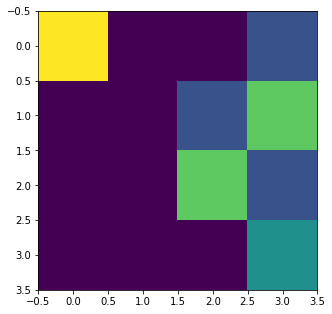

In [15]:
#DETERMISTIC environment - run a random agent for atleast 10 timesteps
deterenv = GridEnvironment(max_timesteps = 15)
observation = deterenv.reset()
print(observation)
deterenv.render()

In [16]:
#Initializing a Random Agent
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return np.random.choice(self.action_space.n)

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

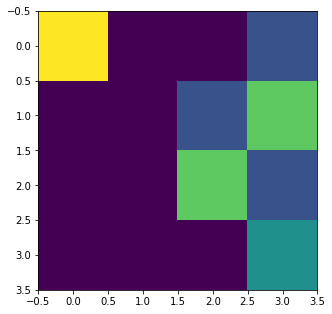

<IPython.core.display.Javascript object>

""


[0 1]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 1]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 1]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 1]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: -1, Action taken: 1, Terminated: True


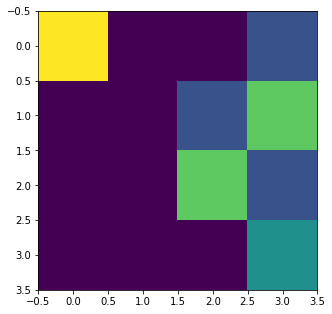

<IPython.core.display.Javascript object>

actions_given [2, 0, 1, 3, 0, 1, 3, 0, 1, 2, 3, 1, 0, 3, 1]
rewards [1, 1, -1, -1, 1, -1, 0, 1, -1, 1, -1, 0, 1, 0, -1]
cumulative reward 0


In [17]:
#Deterministic Environment
det_agent= RandomAgent(env= deterenv)
det_observation= deterenv.reset()
terminated = False

det_output_grid= widgets.Grid(1, 1)

# Test render of environment within widget grid
with det_output_grid.output_to(0, 0):
  deterenv.render()

actions_given = []
rewards = []
observations = []

output_grid = widgets.Grid(1,1)

# MDP loop
while not terminated:
  action= det_agent.step(det_observation)

  observation, reward, terminated, truncated, info= deterenv.step(action)
  actions_given.append(action)
  rewards.append(reward)
  observations.append(observation)
  with output_grid.output_to(0,0):
    output_grid.clear_cell()
    deterenv.render()
    print(f'Reward: {reward}, Action taken: {action}, Terminated: {terminated}')
  time.sleep(1)
print("actions_given", actions_given)
print("rewards", rewards)
print("cumulative reward",sum(rewards))
     


(array([1.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.75, 0.  , 0.  , 0.75,
       0.25, 0.  , 0.  , 0.  , 0.5 ]), {})


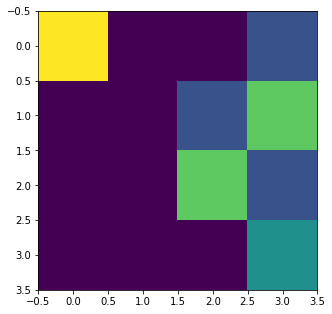

In [18]:
stocenv = GridEnvironment(stochastic=True,max_timesteps = 15)
observation = stocenv.reset()
print(observation)
stocenv.render()

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

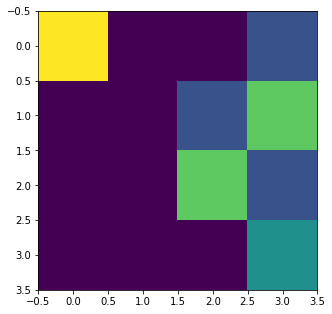

<IPython.core.display.Javascript object>

""


[0 1]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 2]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 3]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 3]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2 3]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2 3]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2 3]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2 3]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2 3]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[3 3]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 11, Action taken: 3, Terminated: True
{'action_given': 3, 'action_taken': 0}


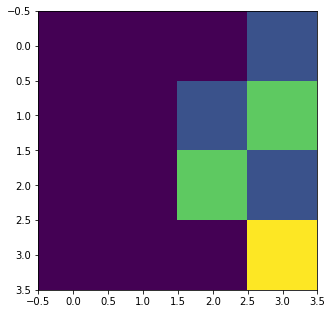

<IPython.core.display.Javascript object>

actions_given [1, 1, 2, 2, 0, 0, 2, 0, 1, 3]
rewards [1, 1, 6, -7, 8, 7, 5, 5, 5, 11]
cumulative reward 42


In [19]:
#Stochastic Environment
stoc_agent= RandomAgent(env= stocenv)
stoc_observation= stocenv.reset()
terminated = False

stoc_output_grid= widgets.Grid(1, 1)

# Test render of environment within widget grid
with stoc_output_grid.output_to(0, 0):
  stocenv.render()

actions_given = []
rewards = []
observations = []

output_grid = widgets.Grid(1,1)

# MDP loop
while not terminated:
  action= stoc_agent.step(stoc_observation)
  observation, reward, terminated, truncated, info= stocenv.step(action)
  actions_given.append(action)
  rewards.append(reward)
  observations.append(observation)
  with output_grid.output_to(0,0):
    output_grid.clear_cell()
    stocenv.render()
    print(f'Reward: {reward}, Action taken: {action}, Terminated: {terminated}')
    print(info)
  time.sleep(1)
print("actions_given", actions_given)
print("rewards", rewards)
print("cumulative reward",sum(rewards))
     
